In [1]:
import numpy as np
import pandas as pd
import os
import csv
import ast
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import wquantiles

from wquantiles import quantile
from openfisca_survey_manager.utils import asof

from openfisca_france_indirect_taxation import FranceIndirectTaxationTaxBenefitSystem
from openfisca_france_indirect_taxation.examples.utils_example import (
    wavg,
    collapse,
    dataframe_by_group,
    graph_builder_bar,
    df_weighted_average_grouped)
from openfisca_france_indirect_taxation.build_survey_data.utils import weighted_sum
from openfisca_france_indirect_taxation.almost_ideal_demand_system.utils import add_niveau_vie_decile
from openfisca_france_indirect_taxation.surveys import SurveyScenario
from openfisca_france_indirect_taxation.calibration import get_inflators_by_year_energy
from openfisca_france_indirect_taxation.utils import assets_directory, get_input_data_frame
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Utils import weighted_quantiles

In [2]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.new_calage_bdf_cn import (
    new_get_bdf_aggregates,
    new_get_cn_aggregates,
    new_get_inflators_bdf_to_cn,
    new_get_inflators_cn_to_cn,
    new_get_inflators,
    new_get_inflators_by_year)

In [3]:

simulated_variables = ['depenses_tva_taux_plein',
'depenses_tva_taux_intermediaire',
'depenses_tva_taux_reduit',
'depenses_tva_taux_super_reduit',
'depenses_tva_exonere',
'depenses_totales',
 'niveau_de_vie',
 'niveau_vie_decile',
 'rev_disponible',
 'pondmen',
 'situapr',
 'situacj',
 'nactifs',
 'npers']

In [4]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Reform_TVA_budget_2025 import augmente_tous_les_taux

In [5]:
year = 2024
data_year = 2017
inflators_by_year = new_get_inflators_by_year(rebuild = False, year_range = range(2017, 2025), data_year = data_year)
tax_benefit_system = FranceIndirectTaxationTaxBenefitSystem()
inflation_kwargs = dict(inflator_by_variable = inflators_by_year[year])

In [6]:
survey_scenario = SurveyScenario.create(
    inflation_kwargs =  inflation_kwargs,
    baseline_tax_benefit_system = tax_benefit_system,
    reform = augmente_tous_les_taux,
    year = year,
    data_year = data_year
    )

In [7]:
baseline_menage = survey_scenario.create_data_frame_by_entity(simulated_variables, filter_by = 'rev_disponible > 0', use_baseline = True, period = 2024)['menage']
reform_menage = survey_scenario.create_data_frame_by_entity(simulated_variables, filter_by = 'rev_disponible > 0', period = 2024)['menage']

In [8]:
difference_menage = pd.DataFrame()
for taux in ['plein','intermediaire', 'reduit', 'super_reduit']:
    difference_menage['depenses_tva_taux_{}'.format(taux)] = baseline_menage['depenses_tva_taux_{}'.format(taux)] - reform_menage['depenses_tva_taux_{}'.format(taux)] 
difference_menage[['rev_disponible','niveau_de_vie','niveau_vie_decile','pondmen','situapr','situacj','nactifs','npers']] = baseline_menage[['rev_disponible','niveau_de_vie','niveau_vie_decile','pondmen','situapr','situacj','nactifs','npers']]
difference_menage['actifs'] = difference_menage['nactifs'] > 0

In [9]:
difference_menage['cinquantieme_niveau_vie'] = weighted_quantiles(difference_menage['niveau_de_vie'], labels = np.arange(1,51), weights = difference_menage['pondmen'], return_quantiles=False)

In [10]:
perc_2 = difference_menage.loc[difference_menage['cinquantieme_niveau_vie'] == 1, :]
list_var = perc_2.columns.tolist()
list_var.remove('pondmen')
average_perc_2 = df_weighted_average_grouped(perc_2,'actifs',list_var)
average_perc_2['pondmen'] = perc_2.groupby(by = 'actifs')['pondmen'].sum()
average_perc_2['npers']=average_perc_2['npers'].round()
average_perc_2['actifs'] = average_perc_2['actifs'].astype('bool')

difference_menage = difference_menage.loc[difference_menage['cinquantieme_niveau_vie'] > 1] 
difference_menage = pd.concat([difference_menage,average_perc_2])
difference_menage = difference_menage.reset_index().drop('index', axis = 1) 

In [11]:
difference_indiv = difference_menage.loc[difference_menage.index.repeat(difference_menage['npers'])]
difference_indiv['quantile_indiv_niveau_vie'] = weighted_quantiles(difference_indiv['niveau_de_vie'], labels = np.arange(1,11), weights = difference_indiv['pondmen'], return_quantiles=False)
difference_indiv['quantile_indiv_niveau_vie'] = difference_indiv['quantile_indiv_niveau_vie'].astype(int)

In [12]:
difference_menage['npers'].sum(), len(difference_indiv)

(28122.0, 28122)

In [13]:
liste_taux = ['plein','intermediaire', 'reduit', 'super_reduit']
for taux in liste_taux:
   difference_indiv['Taux_effort_tva_taux_{}'.format(taux)] = difference_indiv['depenses_tva_taux_{}'.format(taux)] / difference_indiv['niveau_de_vie'] * 100
   
difference_by_decile = df_weighted_average_grouped(dataframe = difference_indiv, groupe = 'quantile_indiv_niveau_vie', varlist = ['depenses_tva_taux_{}'.format(taux) for taux in ['plein','intermediaire', 'reduit', 'super_reduit']]+
                                                   ['Taux_effort_tva_taux_{}'.format(taux) for taux in ['plein','intermediaire', 'reduit', 'super_reduit']])


In [14]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Utils import stacked_bar_plot

In [16]:
difference_by_decile['depenses_tva_totales'] = difference_by_decile[['depenses_tva_taux_{}'.format(taux) for taux in ['plein','intermediaire', 'reduit', 'super_reduit']]].sum(axis = 1)

In [17]:
difference_by_decile

,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,Taux_effort_tva_taux_plein,Taux_effort_tva_taux_intermediaire,Taux_effort_tva_taux_reduit,Taux_effort_tva_taux_super_reduit,depenses_tva_totales
quantile_indiv_niveau_vie,,,,,,,,,
1,-118.530023,-31.543739,-72.739021,-2.660687,-0.958749,-0.280628,-0.582754,-0.021574,-225.473469
2,-142.525717,-32.378264,-80.388305,-4.174858,-0.717256,-0.163138,-0.403129,-0.021075,-259.467144
3,-147.047176,-38.069156,-80.887133,-3.639131,-0.611372,-0.157526,-0.335925,-0.015073,-269.642596
4,-173.635372,-46.691480,-94.381714,-4.490855,-0.626192,-0.169131,-0.340413,-0.016283,-319.199420
5,-185.325720,-55.883245,-96.382009,-5.883547,-0.591876,-0.179431,-0.308356,-0.018762,-343.474521
6,-199.712881,-93.242462,-109.273937,-5.969289,-0.571917,-0.267210,-0.312812,-0.017067,-408.198570
7,-210.437785,-65.741719,-112.597327,-5.511718,-0.539821,-0.168845,-0.288905,-0.014145,-394.288549
8,-236.062983,-82.788743,-130.981799,-6.738011,-0.534730,-0.189081,-0.296488,-0.015295,-456.571536
9,-256.819376,-94.506643,-140.146429,-8.929189,-0.492187,-0.179256,-0.268630,-0.017110,-500.401637


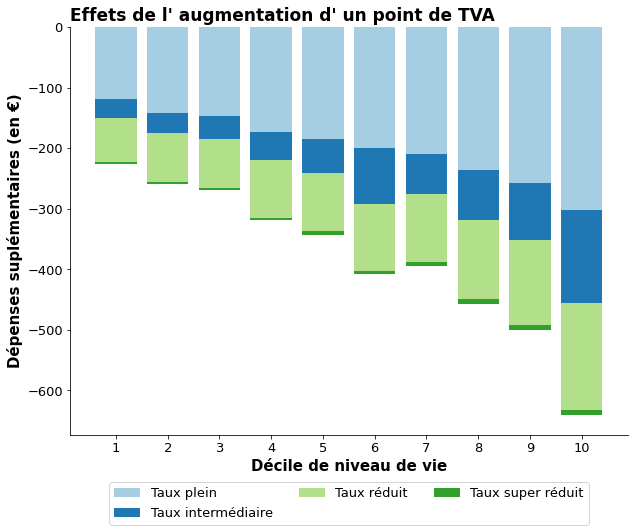

In [18]:
stacked_bar_plot(difference_by_decile, 
                 variables = ['depenses_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = 'Effets de l\' augmentation d\' un point de TVA',
                 xlabel = 'Décile de niveau de vie' ,
                 ylabel ='Dépenses suplémentaires (en €)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Effet_net_augmentation_TVA.pdf')

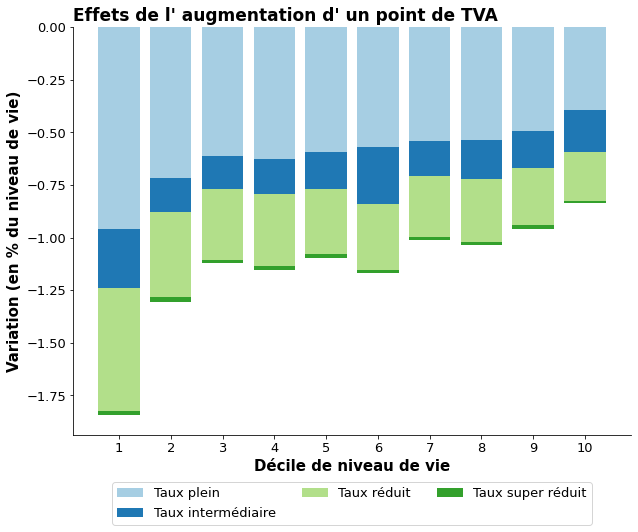

In [19]:
stacked_bar_plot(difference_by_decile, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = 'Effets de l\' augmentation d\' un point de TVA',
                 xlabel = 'Décile de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort.pdf')

In [20]:
difference_by_decile_actifs_only = df_weighted_average_grouped(dataframe = difference_indiv[difference_indiv['actifs'] == True], groupe = 'quantile_indiv_niveau_vie', varlist = ['depenses_tva_taux_{}'.format(taux) for taux in ['plein','intermediaire', 'reduit', 'super_reduit']]+
                            ['Taux_effort_tva_taux_{}'.format(taux) for taux in ['plein','intermediaire', 'reduit', 'super_reduit']])


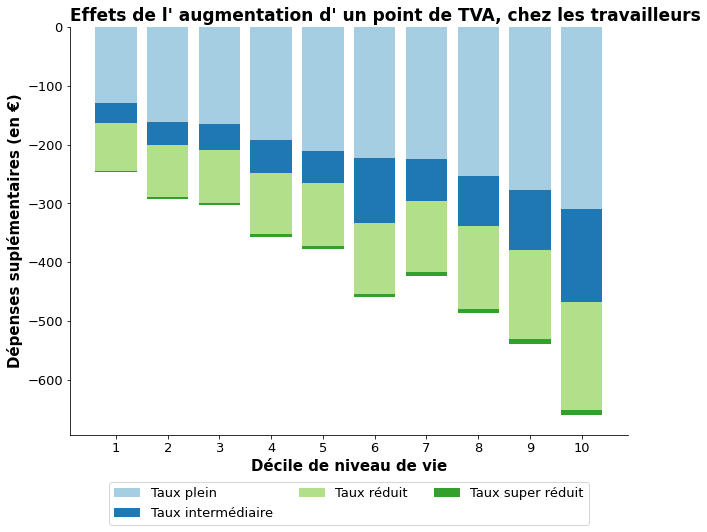

In [21]:
stacked_bar_plot(difference_by_decile_actifs_only, 
                 variables = ['depenses_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = 'Effets de l\' augmentation d\' un point de TVA, chez les travailleurs',
                 xlabel = 'Décile de niveau de vie' ,
                 ylabel ='Dépenses suplémentaires (en €)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Effet_net_augmentation_TVA_actifs_only.pdf')

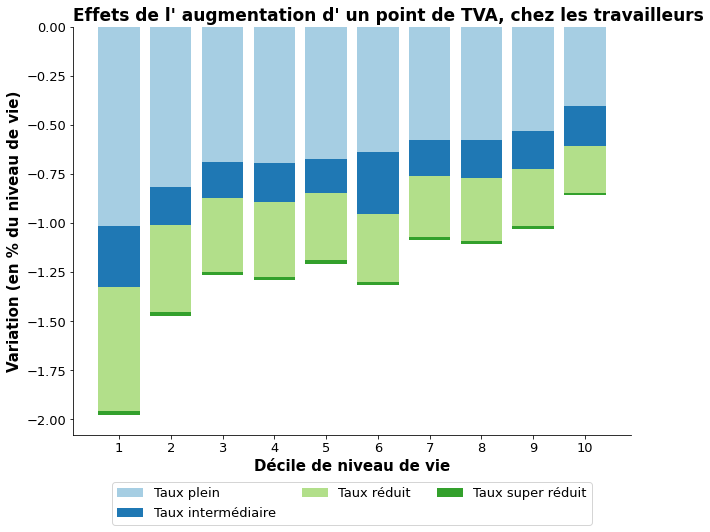

In [22]:
stacked_bar_plot(difference_by_decile_actifs_only, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = 'Effets de l\' augmentation d\' un point de TVA, chez les travailleurs',
                 xlabel = 'Décile de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort_actifs_only.pdf')

In [23]:
difference_by_decile_not_actifs = df_weighted_average_grouped(dataframe = difference_indiv[difference_indiv['actifs'] == False], groupe = 'quantile_indiv_niveau_vie', varlist = ['depenses_tva_taux_{}'.format(taux) for taux in ['plein','intermediaire', 'reduit', 'super_reduit']]+
                            ['Taux_effort_tva_taux_{}'.format(taux) for taux in ['plein','intermediaire', 'reduit', 'super_reduit']])

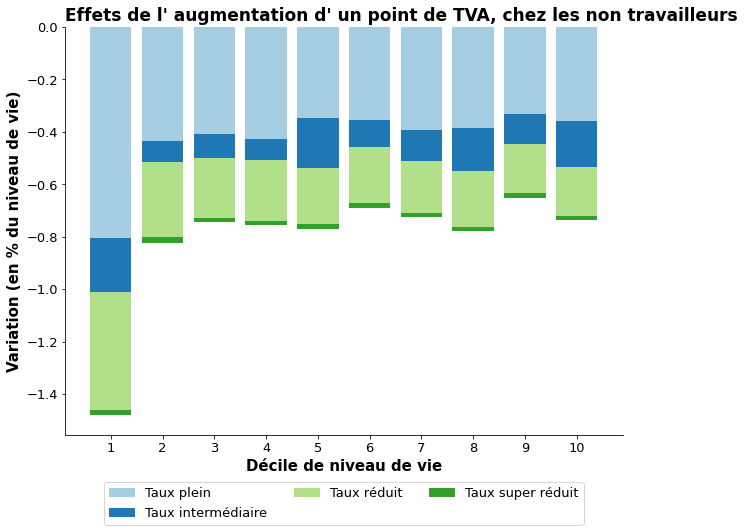

In [24]:
stacked_bar_plot(difference_by_decile_not_actifs, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = 'Effets de l\' augmentation d\' un point de TVA, chez les non travailleurs',
                 xlabel = 'Décile de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort_not_actifs.pdf')